# Sentiment Analysis Using Pre-Trained Model (BERT) in Pytorch

Setup

In [1]:
pip install transformers

     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 55.5 MB/s 
     |████████████████████████████████| 880 kB 47.6 MB/s 
     |████████████████████████████████| 84 kB 2.8 MB/s 
     |████████████████████████████████| 6.6 MB 47.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=3a0b9e81de9c42b3b79fee0119f0a194d3e6e9963b0fbd7e12c0b9084173cc09
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
pip install datasets

     |████████████████████████████████| 342 kB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 64.3 MB/s 
     |████████████████████████████████| 136 kB 42.4 MB/s 
     |████████████████████████████████| 212 kB 45.7 MB/s 
     |████████████████████████████████| 127 kB 44.7 MB/s 
     |████████████████████████████████| 144 kB 42.5 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 271 kB 44.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
pip install scikit-plot

In [4]:
from transformers import BertTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from scikitplot.metrics import plot_confusion_matrix

In [5]:
!nvidia-smi

Wed May 11 19:58:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Data set

In [6]:
# IMDB dataset

imdb = load_dataset('imdb')
print(imdb)

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


Data Pre-Processsing

In [7]:
#Tokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

inputs = imdb.map(tokenize_function, batched=True, batch_size=None)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [8]:
print(inputs['train'].column_names)

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


Pre-Trained Model

In [9]:
#BERT Model

model = (AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2))

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [10]:
#Evaluation metrics

def metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [11]:
#Arguments

model_name = 'BERT Classifier of IMDB Data set'

batch_size = 16

logging_steps = len(inputs['train']) // batch_size

training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  logging_steps=logging_steps,
                                  evaluation_strategy='epoch',
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size)

In [12]:
#Trainer

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=metrics,
                  train_dataset=inputs['train'],
                  eval_dataset=inputs['test'],
                  tokenizer=tokenizer)

trainer.train();

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 25000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3126


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.258800,0.197550,0.921880,0.921715
2,0.115600,0.214713,0.941040,0.941037


Saving model checkpoint to BERT Classifier of IMDB Data set/checkpoint-500
Configuration saved in BERT Classifier of IMDB Data set/checkpoint-500/config.json
Model weights saved in BERT Classifier of IMDB Data set/checkpoint-500/pytorch_model.bin
tokenizer config file saved in BERT Classifier of IMDB Data set/checkpoint-500/tokenizer_config.json
Special tokens file saved in BERT Classifier of IMDB Data set/checkpoint-500/special_tokens_map.json
Saving model checkpoint to BERT Classifier of IMDB Data set/checkpoint-1000
Configuration saved in BERT Classifier of IMDB Data set/checkpoint-1000/config.json
Model weights saved in BERT Classifier of IMDB Data set/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in BERT Classifier of IMDB Data set/checkpoint-1000/tokenizer_config.json
Special tokens file saved in BERT Classifier of IMDB Data set/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to BERT Classifier of IMDB Data set/checkpoint-1500
Configuration saved i

In [13]:
preds_output = trainer.predict(inputs['test'])

preds_output.metrics

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 25000
  Batch size = 16


{'test_accuracy': 0.94104,
 'test_f1': 0.9410368059873656,
 'test_loss': 0.21471287310123444,
 'test_runtime': 440.4846,
 'test_samples_per_second': 56.756,
 'test_steps_per_second': 3.548}

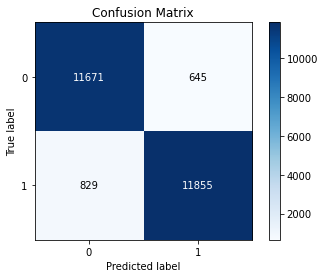

In [14]:
y_preds = np.argmax(preds_output.predictions, axis=1)

y_valid = np.array(inputs['test']['label'])

labels = inputs["train"].features["label"].names

plot_confusion_matrix(y_preds, y_valid)